# Building an 2D Ising film

Let's build a 2D Ising film with simple cubic structure and periodic boundary conditions.

Import the required libraries

* [numpy](http://www.numpy.org/) handles numeric arrays and mathematical operations.
* [product](https://docs.python.org/3.7/library/itertools.html#itertools.product) returns cartesian product of input iterables.
* [matplotlib](https://matplotlib.org/) produces figures.
* [defaultdict](https://docs.python.org/3.7/library/collections.html#collections.defaultdict) is a dictionary where each *value* has a defined type.

In [1]:
import numpy
from itertools import product
from matplotlib import pyplot
from collections import defaultdict

Define the edge length of the film (```L```) measured in magnetic unit cells (muc).

In [2]:
L = 10

Define the spin value (```spin```) and the nearest neighbors exchange interaction constant (```jex```). ```jex = 1.0``` is taken as the unit of energy. Also, define the [update policy](https://pcm-ca.github.io/vegas/spin-update-policies/) for the direction of the magnetic moments. In this case, the spin update policy is an spin flip (```flip```) to recreate the Ising model.

In [3]:
spin = 1.0
kan = 0.0
jex = 1.0
update_policy = "flip"

Create a list of sites.

In [4]:
sites = list()
for site in product(range(0, L), range(0, L), range(0, 1)):
    sites.append(site)

Convert the previous list to numpy arrays.

In [5]:
positions = numpy.array(sites)

Generate a 2D plot of the film.

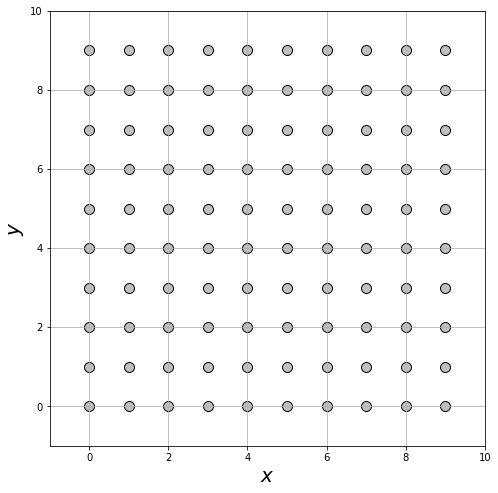

In [6]:
fig = pyplot.figure(figsize=(8, 8))
pyplot.scatter(positions[:, 0], positions[:, 1],
           s=100, color="silver", edgecolor="black")
pyplot.grid()
pyplot.xlabel(r"$x$", fontsize=20)
pyplot.ylabel(r"$y$", fontsize=20)
pyplot.xlim(-1, L)
pyplot.ylim(-1, L)
pyplot.gca().set_aspect("equal")
pyplot.show()

Identify the neighbors of each magnetic moment and store them in a dictionary. Periodic boundary conditions are established. Because all the sites are located in the $xy$ plane, periodic boundary conditions are imposed in the $x$ and $y$ directions, but they are not imposed in the $z$ direction.

In [7]:
nhbs = defaultdict(list)
for site in sites:
    x, y, z = site
    for dx, dy in [(1.0, 0.0),
                   (-1.0, 0.0),
                   (0.0, 1.0),
                   (0.0, -1.0)]:
        nhb = ((x + dx) % L, (y + dy) % L, z)
        if nhb in sites:
            nhbs[site].append(nhb)

Make some verifications: that each site has $4$ neighbors, that the neighbors of each site are $1.0$ muc away, and that each site is in the neighbors list of each of its neighbors. If two sites are neighbors because of the periodic boundary conditions, they are not $1.0$ muc away. However, one of the $9$ replicas must be this distance away.

In [8]:
for site in sites:
    assert len(nhbs[site]) == 4
    for nhb in nhbs[site]:
        assert site in nhbs[nhb]
        
        dists = list()
        for x in [-L, 0, L]:
            for y in [-L, 0, L]:
                dists.append(numpy.linalg.norm(numpy.array(site) + (x, y, 0) - numpy.array(nhb)))
        assert (9 - numpy.count_nonzero(numpy.array(dists) - 1.0) == 1)

Create a dictionary to identify the type of each site, which in this case is ```generic``` for all sites.

In [9]:
types = dict()
for site in sites:
    types[site] = "generic"

The external magnetic field is applied along the $+z$ axis.

In [10]:
field_axis = dict()
for site in sites:
    field_axis[site] = (0.0, 0.0, 1.0)

Count the number of interactions equal to the sum of the neighbors of each site, and the number of sites as the length of the list of the sites.

In [11]:
num_interactions = 0
for site in sites:
    num_interactions += len(nhbs[site])
num_sites = len(sites)

The number of interactions must be equal to the number of sites multiplied by $4$. This is because, due to the periodic boundary conditions, each site has $4$ neighbors.

In [12]:
assert (num_interactions == (num_sites * 4))

Create the file to store the sample.

In [13]:
sample_file = open("sample_L_%s.dat" % L, mode="w")

Write in the first line of ```sample_file``` the number of sites, interactions and types:

In [14]:
sample_file.write("{} {} {}\n".format(num_sites, num_interactions, len(set(types.values()))))
print(num_sites, num_interactions, len(set(types.values())))

100 400 1


Write the ion types on a different line each one.

In [15]:
for t in sorted(set(types.values())):
    sample_file.write("{}\n".format(t))
    print(t)

generic


Write the parameters of each site according to the established [format](https://pcm-ca.github.io/vegas/system-building/).

In [16]:
for site in sites:
    i = sites.index(site)
    t = types[site]
    sample_file.write("{} {} {} {} {} {} {} {} {} {}\n".format(
        i, *site, spin, *field_axis[site], t, update_policy))

Write the exchange interactions between every pair of neighbors.

In [17]:
for site in sites:
    t = types[site]
    for nhb in nhbs[site]:
        nhb_t = types[nhb]
        sample_file.write("{} {} {}\n".format(
            sites.index(site), sites.index(nhb), jex))

Close the file.

In [18]:
sample_file.close()

The result of this script is the creation of one file: ```sample.dat```, which stores the structural properties of the 2D Ising film.